# Create an error-correcting DDM workflow

This notebook documents the workflow used to identify, analyze and correct the errors associated with using a physically based model (MODFLOW) for hydrological (groundwater/surface-water) simulation.

Based on DDM-UQ (Data Driven Model-Uncertainty Quantification) framework specified in Xu and Valocchi, 2015.

This notebook uses the Python version of the MATLAB based DDM-UQ toolbox.


## References

### DDM:

* https://wiki.illinois.edu/wiki/display/mlgwm/Home

* T. Xu, A. J. Valocchi, 2015. Data-driven Methods to Improve Baseflow Prediction of a Regional Groundwater Model. Computers and Geociences. doi: 10.1016/j.cageo.2015.05.016

* T. Xu, A. J. Valocchi, J. Choi, E. Amir, 2013. Use of Machine Learning Methods to Reduce Predictive Error of Groundwater Models. Groundwater. doi: 10.1111/gwat.12061


## Contact author:

Rishi Jumani; unbiased.modeler@gmail.com

# Main concepts


## Account for three main types of errors

* Structural errors

* Paramter errors

* Measurement errors

## Advantages of using DDM:

* Works for errors from multiple sources, and does not make any assumptions about the error distribution

* May be possible for the DDM to generalize to new hydrogeological conditions, that differ from the training data



## Disadvantages of using DDM:

* Requires existence of structural errors (spatial and temporal patterns). Might not be suitable for well calibrated models (calibration error follows Gaussian distribution with zero mean and variance similar to observation error). - ** This workflow attempts to address this disadvantage by including more input features than considered in the papers  **

* DDM may not conserve mass


## Residual Analysis

* Learn a relation between the residuals (errors) and the input factors.

* Model the spatio-temporal residuals - uncover the bias, correlation, heteroscedasticity in the results, by capturing the systematic patterns in the residuals.



## Machine Learning

### Support Vector Machine (SVM)

* Goal: Find a relation between the residual $\epsilon$ and selected model inputs $\mathbf{x}$:

### $$\epsilon = \hat{\epsilon}(\mathbf{x})$$

* Train the DDM with the help of a test dataset.

* Has good generalization performance, and finds the global minima.

* Minimize the upper bound of the generalization error rather than minimizing the training error



## Error Variance Analysis (EVA)




## Structural Errors






## Further work

* Build local DDM (based on clustering the residuals, so that residuals in the same cluster have similar characteristics)








## Freyberg Model

In [1]:
%matplotlib inline
import os
import sys
sys.path.append("..")
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pyemu
import flopy

In [2]:
# declare the file names and path to the model

pst_name = 'freyberg_un.pst'
working_dir = 'freyberg_k/freyberg_un'

nam_file = 'freyberg.nam'

## Model Calibration

### Calibrated Parameters:

* Hydraulic Conductivity

* Other parameters that will be added: recharge, 


### Observations used for Calibration:

* Head measurements

* Baseflow

### Calibration Technique

* Regular PEST calibration - minimize measurement objective function 

* (Pilot Points will also be used)


### Software used

pyEMU and PEST++

## Residual Analysis

* Compute Mean Error (ME) of the head (negative value if simulated head $>$ observed head): if magnitude of ME is large, this would indicate bias in the residuals

* Use residual plots to estimate bias and heteroscedasticity

* Construct a semivariogram to examine the spatial correlation in the residual

* Use Q-Q plot to test for Gaussianity

* Use the Durbin-Watson (DW) test to examine the  temporal correlation (auto-correlation) in the residual

### Compute and plot the Mean Error (ME) of the head

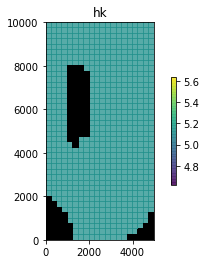

In [3]:
# plot the top layer

m = flopy.modflow.Modflow.load(nam_file,model_ws=working_dir)
#ax = m.upw.hk[0].plot(colorbar=True,alpha=0.5)
m.upw.hk[0].plot(colorbar=True,alpha=0.5)

,name,group,measured,modelled,residual,weight
name,,,,,,
c001pr01c01_19700102,c001pr01c01_19700102,head,2.732159e+01,3.068697e+01,-3.365379e+00,1.0
c001pr01c02_19700102,c001pr01c02_19700102,head,2.722244e+01,3.053177e+01,-3.309334e+00,1.0
c001pr01c03_19700102,c001pr01c03_19700102,head,2.699432e+01,3.019685e+01,-3.202530e+00,1.0
c001pr01c04_19700102,c001pr01c04_19700102,head,2.660399e+01,2.967958e+01,-3.075586e+00,1.0
c001pr01c05_19700102,c001pr01c05_19700102,head,2.618012e+01,2.911749e+01,-2.937378e+00,1.0
c001pr01c06_19700102,c001pr01c06_19700102,head,2.571591e+01,2.846544e+01,-2.749527e+00,1.0
c001pr01c07_19700102,c001pr01c07_19700102,head,2.509224e+01,2.761985e+01,-2.527607e+00,1.0
c001pr01c08_19700102,c001pr01c08_19700102,head,2.460042e+01,2.691070e+01,-2.310280e+00,1.0
c001pr01c09_19700102,c001pr01c09_19700102,head,2.400153e+01,2.599923e+01,-1.997694e+00,1.0


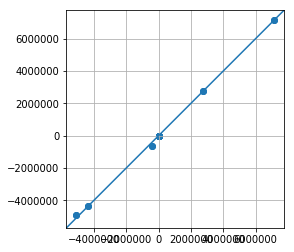

In [4]:
# compute all the residuals

pst = pyemu.Pst(os.path.join(working_dir,pst_name))
res_nz = pst.res.loc[pst.nnz_obs_names,:]
ax = plt.subplot(111,aspect="equal")
ax.scatter(res_nz.modelled,res_nz.measured)
xlim,ylim = ax.get_xlim(),ax.get_ylim()
mx,mn = max(xlim[1],ylim[1]),min(xlim[0],ylim[0])

ax.plot([mn,mx],[mn,mx])
ax.set_xlim(mn,mx)
ax.set_ylim(mn,mx)
ax.grid()
res_nz

In [17]:
# compute the residuals of the head - negative values means sim head is greater

#pst = pyemu.Pst(os.path.join(working_dir,pst_name))
res_nz = pst.res.loc[pst.nnz_obs_names,:]

res_h = res_nz[res_nz['group']=='head'].copy()
res_h

,name,group,measured,modelled,residual,weight
name,,,,,,
c001pr01c01_19700102,c001pr01c01_19700102,head,27.321592,30.686972,-3.365379e+00,1.0
c001pr01c02_19700102,c001pr01c02_19700102,head,27.222437,30.531771,-3.309334e+00,1.0
c001pr01c03_19700102,c001pr01c03_19700102,head,26.994316,30.196846,-3.202530e+00,1.0
c001pr01c04_19700102,c001pr01c04_19700102,head,26.603994,29.679581,-3.075586e+00,1.0
c001pr01c05_19700102,c001pr01c05_19700102,head,26.180117,29.117495,-2.937378e+00,1.0
c001pr01c06_19700102,c001pr01c06_19700102,head,25.715912,28.465439,-2.749527e+00,1.0
c001pr01c07_19700102,c001pr01c07_19700102,head,25.092239,27.619846,-2.527607e+00,1.0
c001pr01c08_19700102,c001pr01c08_19700102,head,24.600422,26.910702,-2.310280e+00,1.0
c001pr01c09_19700102,c001pr01c09_19700102,head,24.001534,25.999228,-1.997694e+00,1.0


In [6]:
res_h_val = res_h['residual']
np.mean(res_h_val)

-0.3903211962920607

In [7]:
pst.phi_components

{'calflux': 5630.949130653428,
 'flx_constan': 31020.816370430784,
 'flx_in-out': 122.82186799347512,
 'flx_percent': 0.032400000321840004,
 'flx_recharg': 5844.602500000001,
 'flx_river_l': 7118.686456806188,
 'flx_storage': 5.1056403612002885,
 'flx_total': 122.82222149291759,
 'flx_wells': 9002.214400019073,
 'foreflux': 0.0,
 'foretrav': 0.0,
 'head': 1340.7299727857358,
 'vol_constan': 86525063517.3107,
 'vol_in-out': 140.821806343093,
 'vol_percent': 0.032400000321840004,
 'vol_recharg': 17625.8525,
 'vol_river_l': 83115769771.44913,
 'vol_storage': 34006504.5,
 'vol_total': 140.8221595049415,
 'vol_wells': 26957.464399999997}

In [13]:
obs = pst.observation_data
hobs = obs.loc[obs.obgnme=="head",:].copy()
hobs.loc[:,"i"] = hobs.obsnme.apply(lambda x: int(x[6:8])-1)
hobs.loc[:,"j"] = hobs.obsnme.apply(lambda x: int(x.split('_')[0].split('c')[-1])-1)
hobs.loc[:,"x"] = m.sr.xcentergrid[hobs.i,hobs.j]
hobs.loc[:,"y"] = m.sr.ycentergrid[hobs.i,hobs.j]
hobs

,obsnme,obsval,weight,obgnme,i,j,x,y
obsnme,,,,,,,,
c001pr01c01_19700102,c001pr01c01_19700102,27.321592,1.0,head,0,0,125.0,9875.0
c001pr01c02_19700102,c001pr01c02_19700102,27.222437,1.0,head,0,1,375.0,9875.0
c001pr01c03_19700102,c001pr01c03_19700102,26.994316,1.0,head,0,2,625.0,9875.0
c001pr01c04_19700102,c001pr01c04_19700102,26.603994,1.0,head,0,3,875.0,9875.0
c001pr01c05_19700102,c001pr01c05_19700102,26.180117,1.0,head,0,4,1125.0,9875.0
c001pr01c06_19700102,c001pr01c06_19700102,25.715912,1.0,head,0,5,1375.0,9875.0
c001pr01c07_19700102,c001pr01c07_19700102,25.092239,1.0,head,0,6,1625.0,9875.0
c001pr01c08_19700102,c001pr01c08_19700102,24.600422,1.0,head,0,7,1875.0,9875.0
c001pr01c09_19700102,c001pr01c09_19700102,24.001534,1.0,head,0,8,2125.0,9875.0


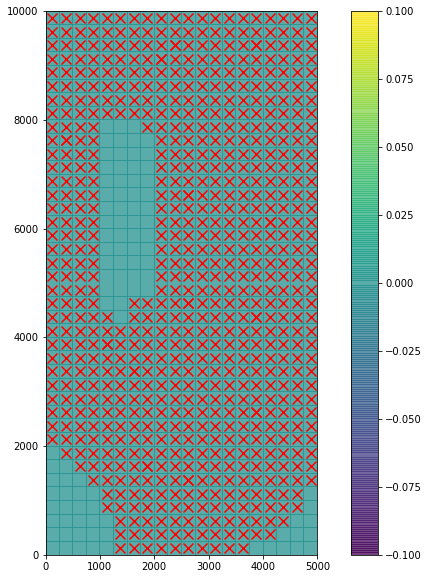

In [14]:
# plot all the observation locations

fig = plt.figure(figsize=(12,10))
ax = plt.subplot(111,aspect="equal")
arr = np.zeros((m.nrow,m.ncol))
c = ax.pcolormesh(m.sr.xedge,m.sr.yedge,arr,alpha=0.75)
plt.colorbar(c)
ax.scatter(hobs.x,hobs.y,marker='x',s=100,color='r')

### Residual Plots

In [15]:
res_h

,name,group,measured,modelled,residual,weight
name,,,,,,
c001pr01c01_19700102,c001pr01c01_19700102,head,27.321592,30.686972,-3.365379e+00,1.0
c001pr01c02_19700102,c001pr01c02_19700102,head,27.222437,30.531771,-3.309334e+00,1.0
c001pr01c03_19700102,c001pr01c03_19700102,head,26.994316,30.196846,-3.202530e+00,1.0
c001pr01c04_19700102,c001pr01c04_19700102,head,26.603994,29.679581,-3.075586e+00,1.0
c001pr01c05_19700102,c001pr01c05_19700102,head,26.180117,29.117495,-2.937378e+00,1.0
c001pr01c06_19700102,c001pr01c06_19700102,head,25.715912,28.465439,-2.749527e+00,1.0
c001pr01c07_19700102,c001pr01c07_19700102,head,25.092239,27.619846,-2.527607e+00,1.0
c001pr01c08_19700102,c001pr01c08_19700102,head,24.600422,26.910702,-2.310280e+00,1.0
c001pr01c09_19700102,c001pr01c09_19700102,head,24.001534,25.999228,-1.997694e+00,1.0


In [21]:
res_h.loc[:,"i"] = res_h.name.apply(lambda x: int(x[6:8])-1)
res_h.loc[:,"j"] = res_h.name.apply(lambda x: int(x.split('_')[0].split('c')[-1])-1)
res_h.loc[:,"x"] = m.sr.xcentergrid[res_h.i,res_h.j]
res_h.loc[:,"y"] = m.sr.ycentergrid[res_h.i,res_h.j]
res_h

,name,group,measured,modelled,residual,weight,i,j,x,y
name,,,,,,,,,,
c001pr01c01_19700102,c001pr01c01_19700102,head,27.321592,30.686972,-3.365379e+00,1.0,0,0,125.0,9875.0
c001pr01c02_19700102,c001pr01c02_19700102,head,27.222437,30.531771,-3.309334e+00,1.0,0,1,375.0,9875.0
c001pr01c03_19700102,c001pr01c03_19700102,head,26.994316,30.196846,-3.202530e+00,1.0,0,2,625.0,9875.0
c001pr01c04_19700102,c001pr01c04_19700102,head,26.603994,29.679581,-3.075586e+00,1.0,0,3,875.0,9875.0
c001pr01c05_19700102,c001pr01c05_19700102,head,26.180117,29.117495,-2.937378e+00,1.0,0,4,1125.0,9875.0
c001pr01c06_19700102,c001pr01c06_19700102,head,25.715912,28.465439,-2.749527e+00,1.0,0,5,1375.0,9875.0
c001pr01c07_19700102,c001pr01c07_19700102,head,25.092239,27.619846,-2.527607e+00,1.0,0,6,1625.0,9875.0
c001pr01c08_19700102,c001pr01c08_19700102,head,24.600422,26.910702,-2.310280e+00,1.0,0,7,1875.0,9875.0
c001pr01c09_19700102,c001pr01c09_19700102,head,24.001534,25.999228,-1.997694e+00,1.0,0,8,2125.0,9875.0


In [28]:
arr = np.zeros((m.nrow,m.ncol))
arr[res_h.i,res_h.j] = res_h.loc[:,'residual']
#arr

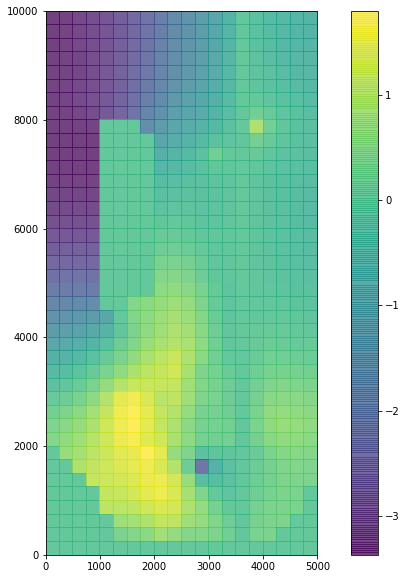

In [29]:
# plot the residuals of the head to get a visual indication of the bias (structural error)

fig = plt.figure(figsize=(12,10))
ax = plt.subplot(111,aspect="equal")
c = ax.pcolormesh(m.sr.xedge,m.sr.yedge,arr,alpha=0.75)
plt.colorbar(c)
#ax.scatter(hobs.x,hobs.y,marker='x',s=100,color='r')

### Analysis of semivariogram

* If the variance of the difference between the residuals at two wells increases as the lag distance increases within the range, this would indicate the existence of spatial dependence

* What is the nugget effect and what is the range? (More prominent nugget effect and smaller range indicate that spatial correlation of error is not as strong)

* Is the density of monitoring wells sufficient: if spatial correlation grows weaker as distance increases, then it is not

### Q-Q plot

### Analysis of DW statistic

The DW statistic tests for $1^{st}$ order auto-correlation

The DW statistic works with time series data with uniform time intervals: only include wells that have relatively uniformly spaced water level measurements

If the DW statistic if a majority of the wells is $<$ 2, this would indicate that the residuals are correlated in time

### Compute Average Mututal Information scores

To check if the historical residuals are related to the well location, simulated head or time of measuremenet

In [2]:
a = 2

In [4]:
%%javascript
MathJax.Hub.Config({
   TeX: { equationNumbers: { autoNumber: "AMS" } }
 });

<IPython.core.display.Javascript object>


## Train the SVM

### Software used: scikit-learn

### Ways to apply the DDM:

* Temporal Prediction during prediction period

* Spatial Predicition

* Spatial-Temporal Prediction


### Basic Theory

* Project the input $\mathbf{x}$ to a higher dimensional feature space with the map $\phi : \mathcal{X} \rightarrow \mathcal{F}$

* Carry out a linear regression in the feature space $\phi(\mathbf{x})$:

$$ f(\mathbf{x}) = \mathbf{w} \cdot \phi (\mathbf{x}) + b $$

* estimate the coefficients $\mathbf{w}$ and b by solving an optimization problem:

$$ \begin{equation} \label{one} 
\mbox{ minimize } \frac{1}{2} || \mathbf{w} ||^2 + C \sum_{i=1}^{n} (\xi_i + \xi_i^*)
\end{equation} $$

$$ \begin{equation} \label{two} 
\mbox{ subject to } (\mathbf{w}^T \phi(\mathbf{x}_i) + b) - y_i \le \varepsilon + \xi_i
\end{equation} $$

$$\begin{equation} \label{three} 
y_i - \left( \mathbf{w}^T \phi(\mathbf{x}_i) + b  \right) \le \varepsilon + \xi_i^*
\end{equation} $$

$$ \begin{equation} \label{four} 
\xi_i, \xi_i^* \ge 0, \mbox{  } i = 1,.., n
\end{equation} $$

* The first term in \eqref{one} represents the complexity of the regression model, and acts as regularization.

* The second term in \eqref{one} represents the goodness-of-fit of the training data

* The slack variables $\xi_i, a\xi_i^*$ are used to cope with infeasible constraints of the optimization problem, and are derived from the $\varepsilon$-insensitive loss function $|\xi|_\varepsilon = max \{0, |y_i - f(\mathbf{x}_i| - \varepsilon \} $

* The constant C, known as the regularization hyper-parameter, in \eqref{one} determines the trade-off between the flatness of f and the deviations exceeding $\varepsilon$

* The map $\phi : \mathcal{X} \rightarrow \mathcal{F}$ is implemented via kernel functions:

$$ \langle \phi (\mathbf{x}_i) , \phi (\mathbf{x}_j) \rangle = K(\mathbf{x}_i, \mathbf{x}_j) $$

* Use an RBF (Radial Basis Function) kernel:

$$ K(\mathbf{x}_i, \mathbf{x}_j) = exp(-\gamma \mbox{  } || \mathbf{x}_i - \mathbf{x}_j ||^2)   $$

### Choose input data

* For temporal and spatio-temporal prediction scenarios, that require the extrapolation of time, including time as an input feature leads to inferior performance of the DDM, while for **spatial prediction**, including time as an input feature yields better performance.

#### Input features for temporal and spatio-temporal predictions:

* Well location $(x_w, y_w)$ of observations

* Simulated head, $\hat{h}$


#### Input features for spatial predictions:

* In addition to the above two factors, also includes time


#### Input parameters to consider:

* Pumping rates

* Boundary Conditions

* Month

* location of observations

* Precip rates

* ET

* difference between groundwater head and streambed elevation

* simulated baseflow


### Selection criteria

* Add input parameters one by one, and accept a parameter if CV error decreases after adding it

### Divide the data into Training and Testing subsets

### Tune the parameters

* Use k-fold cross validation (CV); k chosen as 5, 10

* Data was partitioned differently for spatial and spatio-temporal scenarios, and for temporal scenario

### Parameters to be tuned:

* regularization hyper-parameter, C (determines the complexity of the DDM) 

* loss function parameter $\varepsilon$

* Kernel width parameter $\gamma$

### References

* Cherkassky and Ma, 2004



### Train the DDM

* Use the DDM with the tuned parameters, to re-train the DDM with the entire training dataset




## Test the DDM

### Use the trained DDM to correct the MODFLOW generated residuals

$$ \hat{h}^{new} = \hat{h} + \hat{\epsilon}$$

or 

$$ z_i = M_i + y_i = M_i + \hat{y}(\mathbf{x}_i , \phi) + \varphi_i $$

where $z_i$ is the quantity of interest (head), $M_i$ is the simulated equivalent, $y_i$ is the lumped model residual, $\hat{y}$ is the epistemic term (bias), $\phi$ represents the hyper-parameters and $\varphi_i$ is the aleatoric term (independently distributed random noise), whose distribution is estimated using SVM (parametric approach) .




### Estimate the distribution of the aleatoric term

* Use 10 fold CV once more, and fit a distribution to the CV generalization errors

* Distribution type is chosen on a case-by-case basis - Gaussian is the most widely used noise model; Laplace and Cauchy distributions have pdf that might resemble the shape of the histogram of the aleatoric errors. The Cauchy distribution has heavy tails, which would allow including outliers.

* All 3 distributions have 2 parameters:

 - Gaussian and Laplace: mean and variance
 
 - Cauchy: median and inter-quartile range
 
 * The parameters can be inferred from the CV generalization errors using maximum likelihood estimation (MLE)
 
 * The goodness-of-fit can be assessed by comparing the likelihood corresponding to the estimated parameters (choosing the distribution with the highest likelihood)
 
 * $F(\varphi)$ is the cdf of the fitted distribution.

### Test the DDM

* Use a testing dataset $\{x_i^*, z_i^*\}$

* We have two outputs: $\hat{z}_i^* = M_i^* + \hat{y}_i^*$ and the associated prediction interval $[L_i, U_i]$

* 2 ways to test: does the DDM reduce the the predicitve bias of the PBM, and evaluate the quality of the predicition intervals.

* The DDM-corrected error is $e_i^* = z_i^* - \hat{z}_i^*$. Three statistics to evaluate the error are:

1). PBIAS (percent bias): 

$$ PBIAS = \frac{\sum_{i=1}^m e_i^*}{\sum_{i=1}^m z_i^*} \times 100\%  $$

2). MAE (mean absolute error):

$$ MAE = \frac{1}{m} \sum_{j=1}^m |e_i^*|  $$

3). NSE (Nash-Sutcliffe efficiency) - range of NSE varies from $- \infty$ and $1.0$:

$$ NSE = 1 - \frac{\sum_{j=1}^m (e_i^*)^2}{\sum_{j=1}^m (z_i^* - \bar{z}_i^*)^2}   $$


* The quality of the prediction intervals is evaluated using the prediction interval coverage probability (PICP), defined as the percentage of total observations that fall into the estimated prediction interval:

$$ PICP = \frac{1}{m} \sum_{i=1}^m \mathbf{1} \{ L_i \le z_i^* \le U_i  \}     $$

where $\mathbf{1} \{ L_i \le z_i^* \le U_i  \}  $ is an indicator function that equals $1$ if the observation falls between the interval and $0$ otherwise. A prediction interval with $90\%$ confidence level should theoretically cover $90\%$ os observation data.

## Compute Prediction interval

* Impose the aleatoric error distribution on the DDM-corrected prediction

* The interval $[L_i, U_i]$ can be consructed with a specified confidence level $1 - \alpha$

$$ L_i = M_i + y_i^L = M_i + \hat{y}_i + F^{-1}(\alpha/2)   $$

$$ U_i = M_i + y_i^U = M_i + \hat{y}_i + F^{-1}(1 - \alpha/2)   $$

## Results

* Comparison of pre-DDM and post-DDM based on ME, RMSE; residual plots; hydrographs at representative wells

* Does the DDM remove the global bias - is the ME $\approx$ Zero